# Astrostat Lab 3: Cleaning HST Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

%matplotlib inline

/Users/larryli/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Data read in

In [2]:
# read in data
data = ascii.read('../data/data_headers.dat', data_start=4)
# data columns
data_day_raw = data[0][:]
data_flux_raw = data[1][:]
data_flux_err_raw = data[2][:]

### Other observation info

In [3]:
hst_exposure = 13.2 # seconds
hst_period_minute = 95.48 # minutes
total_orbits = 6

eclipse_duration = 166.484 # seconds
eclipse_period_hour = 2.025026511149096 # hours

observation_start = 57531.87312
first_transit_time = 57531.91792371155

### Data period conversions

In [4]:
data_day_norm = data_day_raw - observation_start
data_hour_norm = data_day_norm * 24
data_second_norm = data_hour_norm * 60

hst_period_hour = hst_period_minute / 60

first_transit_time_hour_normalized = (first_transit_time - observation_start) * 24
second_transit_time_hour_normalized = first_transit_time_hour_normalized + 2 * eclipse_period_hour
third_transit_time_hour_normalized = second_transit_time_hour_normalized + eclipse_period_hour
fourth_transit_time_hour_normalized = third_transit_time_hour_normalized + eclipse_period_hour

eclipse_duration_hour = eclipse_duration / 3600

### A quick look at the raw data

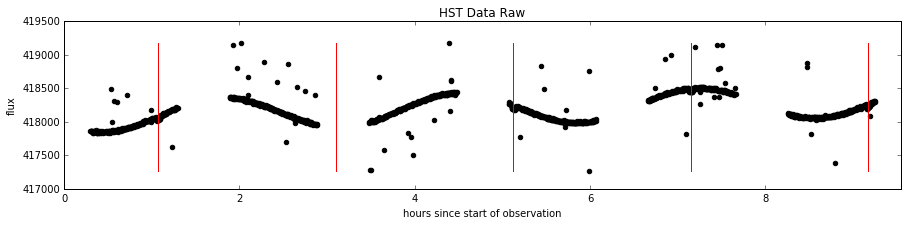

In [215]:
# raw data
fig1 = plt.figure(figsize=(15,3))
ax1 = fig1.add_subplot(111)
ax1.scatter(data_hour_norm, data_flux_raw, marker='o', color='black')

# plots the expected transits
for i in range(0, total_orbits + 1):
    ax1.plot([first_transit_time_hour_normalized + i * eclipse_period_hour,
              first_transit_time_hour_normalized + i * eclipse_period_hour], 
             [np.min(data_flux_raw), np.max(data_flux_raw)], color='red')

ax1.set_xlim([0, total_orbits * hst_period_hour])
ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('HST Data Raw')
fig1.show()
fig1.savefig('../figures/hst_raw.pdf')

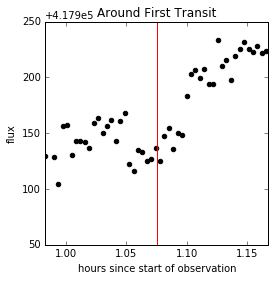

In [6]:
# raw data around first eclipse
fig2 = plt.figure(figsize=(4,4))
ax1 = fig2.add_subplot(111)
ax1.scatter(data_hour_norm, data_flux_raw, marker='o', color='black')
# expected transit lines
ax1.plot([first_transit_time_hour_normalized, first_transit_time_hour_normalized],
         [np.min(data_flux_raw), np.max(data_flux_raw)], color='red')

ax1.set_xlim([first_transit_time_hour_normalized - 2 * eclipse_duration_hour, 
              first_transit_time_hour_normalized + 2 * eclipse_duration_hour])
ax1.set_ylim([417950, 418150])

ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('Around First Transit')
fig2.show()

### Removing outliers

In [7]:
def moving_smooth(series, window, style='median', bin_style='index'):
    '''
    Moving smooth, for ease of implementation let's only input odd windows > 1
    
    Args:
        series [np.array]: of series to be smoothed
        window [int]: odd integer creater than 1 as smoothing window
        style [str]: specific style of smoothing, default 'median'
        
    Returns:
        smoothed_eries [np.array]: of smoothed series with the same shape as input series
    '''
    if bin_style == 'index':
        smoothed_series = np.empty_like(series)

        for i in xrange(len(series)):
            if i - window/2 < 0:
                chunk = series[:i + window/2]
            elif i + window/2 >= len(series):
                chunk = series[i - window/2:]
            else:
                chunk = series[i - window/2:i + window/2]

            if style == 'median':
                smoothed_series[i] = np.median(chunk)
            elif style == 'average':
                smoothed_series[i] = np.mean(chunk)

    elif bin_style == 'time':
        pass

    return smoothed_series

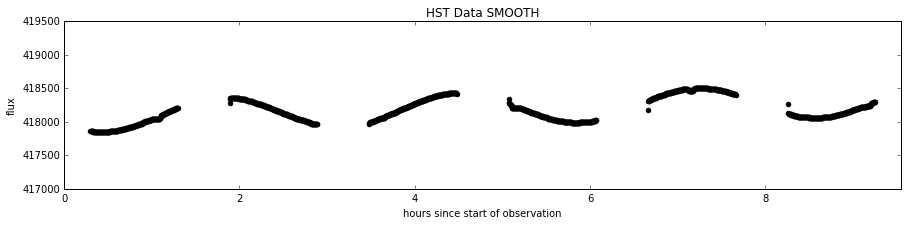

In [8]:
# smoothing test [ignore]
smoothed_test = moving_smooth(data_flux_raw, 25)

fig2 = plt.figure(figsize=(15,3))
ax1 = fig2.add_subplot(111)
ax1.scatter(data_hour_norm, smoothed_test, marker='o', color='black')
ax1.set_xlim([0, total_orbits * hst_period_hour])
ax1.set_ylim([417000, 419500])
ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('HST Data SMOOTH')
fig2.show()

In [9]:
def median_smooth_and_select_outliers(data, data_err, window, sigma):
    """
    Smooth the data with moving median smoothing and then select outliers based on the given sigma
    """
    smoothed_data = moving_smooth(data, window, style='median', bin_style='index')
    smoothed_std_diff = np.abs(smoothed_data - data) / data_err
    outlier_index = np.where(smoothed_std_diff > sigma)[0]

    return outlier_index

In [413]:
# smoothing & outlier selection
smooth_window = 7 # 1/2 of the transit window
# getting outlier index
outlier_sigma_cut = 3 #sigma for outliers
outlier_index = median_smooth_and_select_outliers(data_flux_raw, data_flux_err_raw, smooth_window, outlier_sigma_cut)

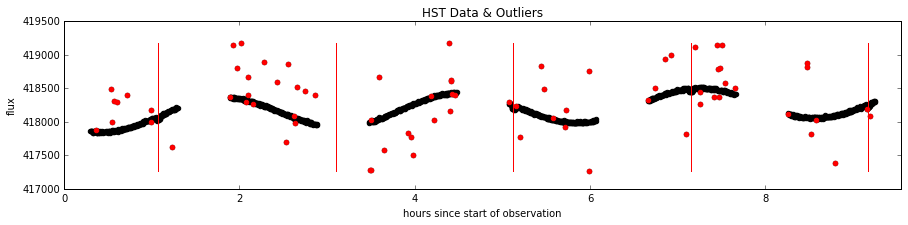

In [414]:
# plotting data with outliers highlighted
fig2 = plt.figure(figsize=(15,3))
ax1 = fig2.add_subplot(111)
ax1.scatter(data_hour_norm, data_flux_raw, marker='o', color='black')
ax1.scatter(data_hour_norm[outlier_index], data_flux_raw[outlier_index], marker='o', color='red')

# plots the expected transits
for i in range(0, total_orbits + 1):
    ax1.plot([first_transit_time_hour_normalized + i * eclipse_period_hour,
              first_transit_time_hour_normalized + i * eclipse_period_hour], 
             [np.min(data_flux_raw), np.max(data_flux_raw)], color='red')

ax1.set_xlim([0, total_orbits * hst_period_hour])
ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('HST Data & Outliers')
fig2.show()
fig2.savefig('../figures/hst_outliers.pdf')

In [415]:
# some stats on outliers
print('Around {0} percent of the original raw data are outliers!'.format(100.*len(outlier_index)/len(data_flux_raw)))

Around 4.73815461347 percent of the original raw data are outliers!


In [13]:
# % outlier and smooth window investigation
windows = np.arange(3,45,2)
percents = []
for w in windows:
    outlier_index = median_smooth_and_select_outliers(data_flux_raw, data_flux_err_raw, w, outlier_sigma_cut)
    percents.append(100.*len(outlier_index)/len(data_flux_raw))

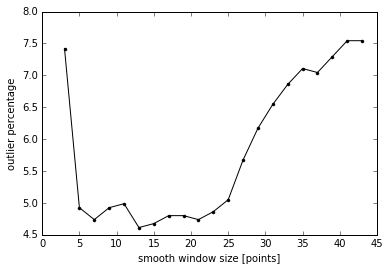

In [131]:
# outlier percents as a function of smooth window size
fig33 = plt.figure()
ax1 = fig33.add_subplot(111)
ax1.plot(windows, percents, marker='.', color='black')
ax1.set_xlabel('smooth window size [points]')
ax1.set_ylabel('outlier percentage')

fig33.show()

In [14]:
# get 'good' data with outliers removed
data_hour_good = np.delete(data_hour_norm, outlier_index)
data_flux_good = np.delete(data_flux_raw, outlier_index)
data_flux_err_good = np.delete(data_flux_err_raw, outlier_index)

### Non-parametric detrending

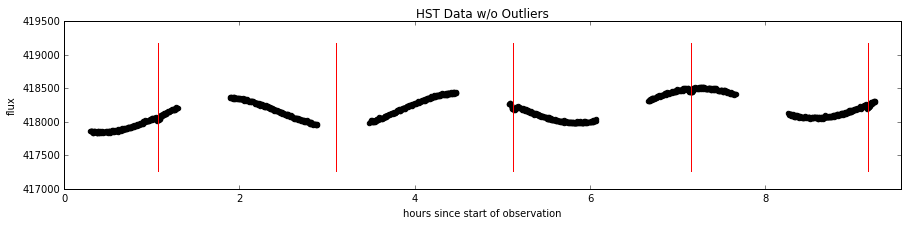

In [217]:
# data without outliers
fig4 = plt.figure(figsize=(15,3))
ax1 = fig4.add_subplot(111)
ax1.scatter(data_hour_good, data_flux_good, marker='o', color='black')

# plots the expected transits
for i in range(0, total_orbits + 1):
    ax1.plot([first_transit_time_hour_normalized + i * eclipse_period_hour,
              first_transit_time_hour_normalized + i * eclipse_period_hour], 
             [np.min(data_flux_raw), np.max(data_flux_raw)], color='red')

ax1.set_xlim([0, total_orbits * hst_period_hour])
ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('HST Data w/o Outliers')
fig4.show()
fig4.savefig('../figures/hst_outliers_removed.pdf')

In [16]:
# detrending initial look
detrend_smooth_window = 37 #  3 times the transit window
detrend_smooth = moving_smooth(data_flux_good, detrend_smooth_window, style='median')

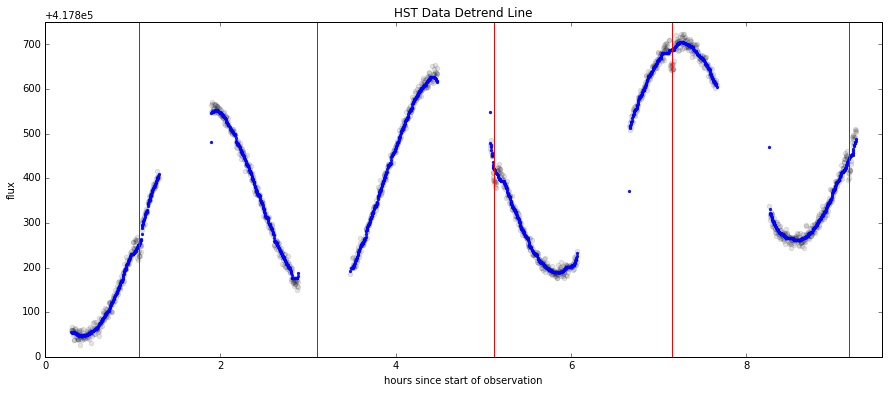

In [218]:
# data with detrend smooth
fig41 = plt.figure(figsize=(15,6))
ax1 = fig41.add_subplot(111)
ax1.scatter(data_hour_good, data_flux_good, marker='o', color='black', alpha=.1)
ax1.scatter(data_hour_good, detrend_smooth, marker='.', color='blue', alpha=.9)

# plots the expected transits
for i in range(0, total_orbits + 1):
    ax1.plot([first_transit_time_hour_normalized + i * eclipse_period_hour,
              first_transit_time_hour_normalized + i * eclipse_period_hour], 
             [np.min(data_flux_raw), np.max(data_flux_raw)], color='red')

ax1.set_xlim([0, total_orbits * hst_period_hour])
ax1.set_ylim([417800, 418550])
ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('HST Data Detrend Line')
fig41.show()
fig41.savefig('../figures/hst_detrend_smooth.pdf')

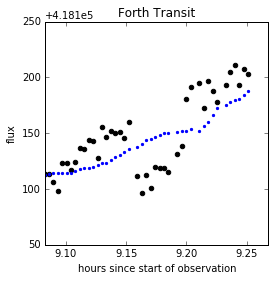

In [18]:
# looking at data with smooth around first eclipse
fig42 = plt.figure(figsize=(4,4))
ax1 = fig42.add_subplot(111)
ax1.scatter(data_hour_good, data_flux_good, marker='o', color='black')
ax1.scatter(data_hour_good, detrend_smooth, marker='.', color='blue')

# plot the transit line
ax1.plot([first_transit_time_hour_normalized, first_transit_time_hour_normalized],
         [np.min(data_flux_raw), np.max(data_flux_raw)], color='red')

ax1.set_xlim([fourth_transit_time_hour_normalized - 2 * eclipse_duration_hour, 
              fourth_transit_time_hour_normalized + 2 * eclipse_duration_hour])
#ax1.set_ylim([417950, 418150])
ax1.set_ylim([418150, 418350])

ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('Forth Transit')
fig2.show()

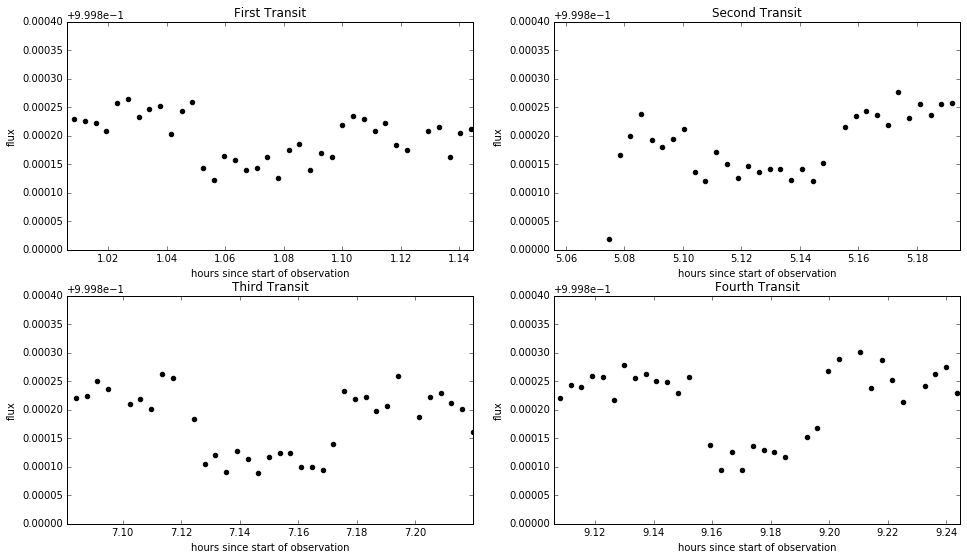

In [219]:
# Plot transit data from overall smooth
width_around_eclipse = 1.5
ylim = [.9998, 1.0002]

fig42 = plt.figure(figsize=(16,9))
ax1 = fig42.add_subplot(221)
ax1.scatter(data_hour_good, data_flux_good / detrend_smooth, marker='o', color='black')

ax1.set_xlim([first_transit_time_hour_normalized - width_around_eclipse * eclipse_duration_hour, 
              first_transit_time_hour_normalized + width_around_eclipse * eclipse_duration_hour])
ax1.set_ylim(ylim)

ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('First Transit')


ax2 = fig42.add_subplot(222)
ax2.scatter(data_hour_good, data_flux_good / detrend_smooth, marker='o', color='black')

ax2.set_xlim([second_transit_time_hour_normalized - width_around_eclipse * eclipse_duration_hour, 
              second_transit_time_hour_normalized + width_around_eclipse * eclipse_duration_hour])
ax2.set_ylim(ylim)

ax2.set_xlabel('hours since start of observation')
ax2.set_ylabel('flux')
ax2.set_title('Second Transit')


ax3 = fig42.add_subplot(223)
ax3.scatter(data_hour_good, data_flux_good / detrend_smooth, marker='o', color='black')

ax3.set_xlim([third_transit_time_hour_normalized - width_around_eclipse * eclipse_duration_hour, 
              third_transit_time_hour_normalized + width_around_eclipse * eclipse_duration_hour])
ax3.set_ylim(ylim)

ax3.set_xlabel('hours since start of observation')
ax3.set_ylabel('flux')
ax3.set_title('Third Transit')


ax4 = fig42.add_subplot(224)
ax4.scatter(data_hour_good, data_flux_good / detrend_smooth, marker='o', color='black')

ax4.set_xlim([fourth_transit_time_hour_normalized - width_around_eclipse * eclipse_duration_hour, 
              fourth_transit_time_hour_normalized + width_around_eclipse * eclipse_duration_hour])
ax4.set_ylim(ylim)

ax4.set_xlabel('hours since start of observation')
ax4.set_ylabel('flux')
ax4.set_title('Fourth Transit')
fig2.show()

### Detrending & relations to window size

In [20]:
# find the observation time gaps in the data
data_gap_index = []
for i in xrange(len(data_hour_good) - 1):
    if data_hour_good[i+1] - data_hour_good[i] > 0.1:
        data_gap_index.append(i)

In [69]:
# data chunking into the 4 eclipes and their respective time and error
e1_data_hour_good = data_hour_good[:data_gap_index[0]]
e1_data_flux_good = data_flux_good[:data_gap_index[0]]
e1_data_flux_err_good = data_flux_err_good[:data_gap_index[0]]

e2_data_hour_good = data_hour_good[data_gap_index[2]+1:data_gap_index[3]]
e2_data_flux_good = data_flux_good[data_gap_index[2]+1:data_gap_index[3]]
e2_data_flux_err_good = data_flux_err_good[data_gap_index[2]+1:data_gap_index[3]]

e3_data_hour_good = data_hour_good[data_gap_index[3]+1:data_gap_index[4]]
e3_data_flux_good = data_flux_good[data_gap_index[3]+1:data_gap_index[4]]
e3_data_flux_err_good = data_flux_err_good[data_gap_index[3]+1:data_gap_index[4]]

e4_data_hour_good = data_hour_good[data_gap_index[4]+1:]
e4_data_flux_good = data_flux_good[data_gap_index[4]+1:]
e4_data_flux_err_good = data_flux_err_good[data_gap_index[4]+1:]

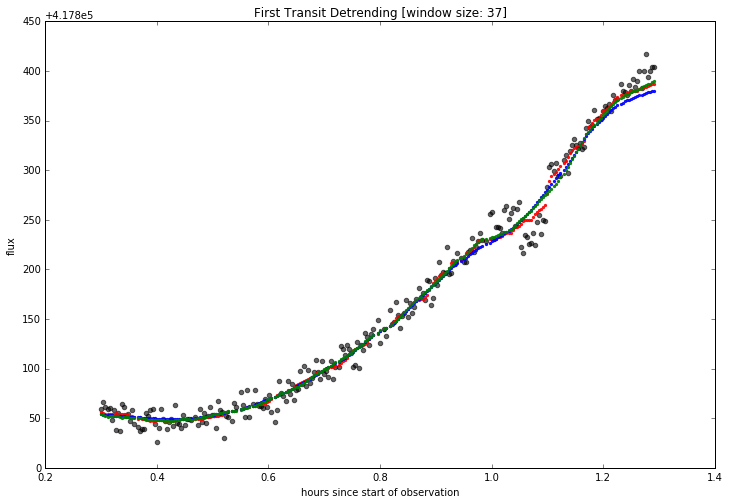

In [22]:
# detrending tests: first eclipse [ignore]

e1_detrend_test_window = 37
e1_detrend_smooth_flux = moving_smooth(e1_data_flux_good, e1_detrend_test_window, style='median')

e1_detrend_smooth_flux2 = moving_smooth(e1_detrend_smooth_flux, 37, style='average')
e1_detrend_smooth_flux3 = moving_smooth(e1_data_flux_good, 37, style='average')

fig51 = plt.figure(figsize=(12,8))
ax1 = fig51.add_subplot(111)
ax1.scatter(e1_data_hour_good, e1_data_flux_good, marker='o', color='black', alpha=.6)
ax1.scatter(e1_data_hour_good, e1_detrend_smooth_flux, marker='.', color='red', alpha=.9)
ax1.scatter(e1_data_hour_good, e1_detrend_smooth_flux2, marker='.', color='blue', alpha=.9)
ax1.scatter(e1_data_hour_good, e1_detrend_smooth_flux3, marker='.', color='green', alpha=.9)

ax1.set_xlabel('hours since start of observation')
ax1.set_ylabel('flux')
ax1.set_title('First Transit Detrending [window size: {0}]'.format(e1_detrend_test_window))
fig51.show()

In [214]:
# FOR GIF MAKING detrending with different window size

for i in xrange(3,123,2):
    e1_detrend_test_window = i
    e1_detrend_smooth_flux = moving_smooth(e1_data_flux_good, e1_detrend_test_window, style='median')

    fig52 = plt.figure(figsize=(12,8))
    ax1 = fig52.add_subplot(111)
    ax1.scatter(e1_data_hour_good, e1_data_flux_good, marker='o', color='black', alpha=.6)
    ax1.scatter(e1_data_hour_good, e1_detrend_smooth_flux, marker='.', color='red', alpha=.9)

    ax1.set_xlabel('hours since start of observation')
    ax1.set_ylabel('flux')
    ax1.set_title('First Transit Detrending [window size: {0}]'.format(e1_detrend_test_window))
    fig52.savefig('../figures/gif/{0}.pdf'.format(e1_detrend_test_window))
    plt.close()

### Individual detrending for each eclipe

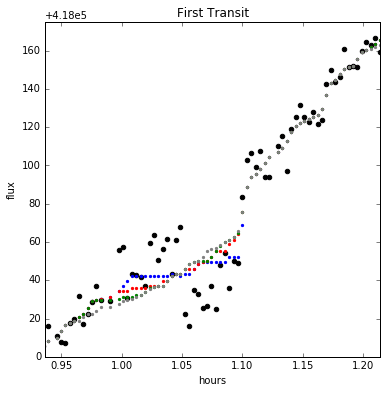

In [220]:
# first eclipse detrending & window selection by eye
new_e1_detrend_smooth1 = moving_smooth(e1_data_flux_good, 25, style='median')
new_e1_detrend_smooth2 = moving_smooth(e1_data_flux_good, 31, style='median')
new_e1_detrend_smooth3 = moving_smooth(e1_data_flux_good, 37, style='median')
new_e1_detrend_smooth4 = moving_smooth(e1_data_flux_good, 49, style='median')

fig621 = plt.figure(figsize=(6,6))
ax1 = fig621.add_subplot(111)
# read data
ax1.scatter(e1_data_hour_good_norm, e1_data_flux_good, marker='o', color='black')
# detrend smooths
ax1.scatter(e1_data_hour_good_norm, new_e1_detrend_smooth1, marker='.', color='blue')
ax1.scatter(e1_data_hour_good_norm, new_e1_detrend_smooth2, marker='.', color='red')
ax1.scatter(e1_data_hour_good_norm, new_e1_detrend_smooth3, marker='.', color='green') #chosen
ax1.scatter(e1_data_hour_good_norm, new_e1_detrend_smooth4, marker='.', color='grey')

ax1.set_xlim([first_transit_time_hour_normalized - 3 * eclipse_duration_hour, 
              first_transit_time_hour_normalized + 3 * eclipse_duration_hour])
ax1.set_ylim([418000, 418175])

ax1.set_xlabel('hours')
ax1.set_ylabel('flux')
ax1.set_title('First Transit')
fig2.show()

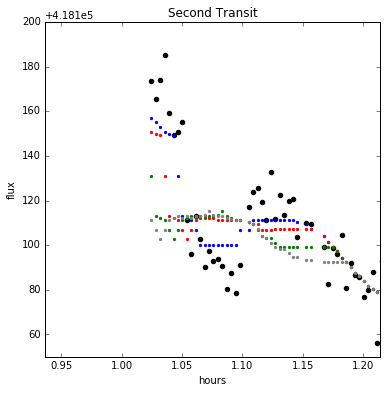

In [221]:
# second eclipse detrending & window selection by eye
new_e2_detrend_smooth1 = moving_smooth(e2_data_flux_good, 21, style='median')
new_e2_detrend_smooth2 = moving_smooth(e2_data_flux_good, 27, style='median')
new_e2_detrend_smooth3 = moving_smooth(e2_data_flux_good, 33, style='median')
new_e2_detrend_smooth4 = moving_smooth(e2_data_flux_good, 39, style='median')

fig622 = plt.figure(figsize=(6,6))
ax1 = fig622.add_subplot(111)
# real data
ax1.scatter(e2_data_hour_good_norm, e2_data_flux_good, marker='o', color='black')
# detrend smooths
ax1.scatter(e2_data_hour_good_norm, new_e2_detrend_smooth1, marker='.', color='blue')
ax1.scatter(e2_data_hour_good_norm, new_e2_detrend_smooth2, marker='.', color='red') 
ax1.scatter(e2_data_hour_good_norm, new_e2_detrend_smooth3, marker='.', color='green')
ax1.scatter(e2_data_hour_good_norm, new_e2_detrend_smooth4, marker='.', color='grey') #chosen
ax1.set_xlim([first_transit_time_hour_normalized - 3 * eclipse_duration_hour, 
              first_transit_time_hour_normalized + 3 * eclipse_duration_hour])
ax1.set_ylim([418150, 418300])

ax1.set_xlabel('hours')
ax1.set_ylabel('flux')
ax1.set_title('Second Transit')
fig2.show()

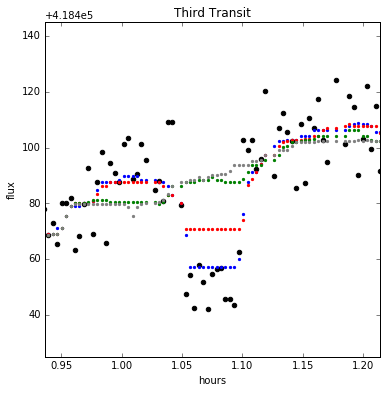

In [222]:
# third eclipse detrending & window selection by eye
new_e3_detrend_smooth1 = moving_smooth(e3_data_flux_good, 23, style='median')
new_e3_detrend_smooth2 = moving_smooth(e3_data_flux_good, 27, style='median')
new_e3_detrend_smooth3 = moving_smooth(e3_data_flux_good, 37, style='median')
new_e3_detrend_smooth4 = moving_smooth(e3_data_flux_good, 47, style='median')

fig623 = plt.figure(figsize=(6,6))
ax1 = fig623.add_subplot(111)
# real data
ax1.scatter(e3_data_hour_good_norm, e3_data_flux_good, marker='o', color='black')
# detrend smooths
ax1.scatter(e3_data_hour_good_norm, new_e3_detrend_smooth1, marker='.', color='blue')
ax1.scatter(e3_data_hour_good_norm, new_e3_detrend_smooth2, marker='.', color='red')
ax1.scatter(e3_data_hour_good_norm, new_e3_detrend_smooth3, marker='.', color='green') 
ax1.scatter(e3_data_hour_good_norm, new_e3_detrend_smooth4, marker='.', color='grey') #chosen

ax1.set_xlim([first_transit_time_hour_normalized - 3 * eclipse_duration_hour, 
              first_transit_time_hour_normalized + 3 * eclipse_duration_hour])
ax1.set_ylim([418425, 418545])

ax1.set_xlabel('hours')
ax1.set_ylabel('flux')
ax1.set_title('Third Transit')
fig2.show()

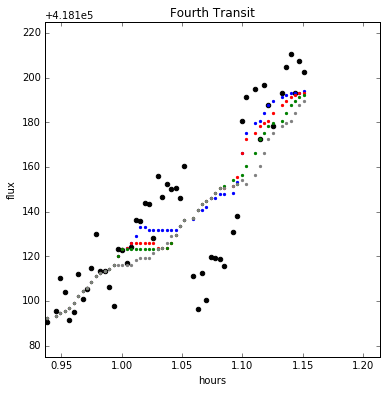

In [223]:
# first eclipse detrending & window selection by eye
new_e4_detrend_smooth1 = moving_smooth(e4_data_flux_good, 23, style='median')
new_e4_detrend_smooth2 = moving_smooth(e4_data_flux_good, 27, style='median')
new_e4_detrend_smooth3 = moving_smooth(e4_data_flux_good, 31, style='median')
new_e4_detrend_smooth4 = moving_smooth(e4_data_flux_good, 35, style='median')

fig624 = plt.figure(figsize=(6,6))
ax1 = fig624.add_subplot(111)
# real data
ax1.scatter(e4_data_hour_good_norm, e4_data_flux_good, marker='o', color='black')
# detrend smooths
ax1.scatter(e4_data_hour_good_norm, new_e4_detrend_smooth1, marker='.', color='blue')
ax1.scatter(e4_data_hour_good_norm, new_e4_detrend_smooth2, marker='.', color='red') #chosen
ax1.scatter(e4_data_hour_good_norm, new_e4_detrend_smooth3, marker='.', color='green')
ax1.scatter(e4_data_hour_good_norm, new_e4_detrend_smooth4, marker='.', color='grey')

ax1.set_xlim([first_transit_time_hour_normalized - 3 * eclipse_duration_hour, 
              first_transit_time_hour_normalized + 3 * eclipse_duration_hour])
ax1.set_ylim([418175, 418325])

ax1.set_xlabel('hours')
ax1.set_ylabel('flux')
ax1.set_title('Fourth Transit')
fig2.show()

In [224]:
# smoothing params
e1_detrend_smooth_window = 37 # all chosen above
e2_detrend_smooth_window = 39
e3_detrend_smooth_window = 47
e4_detrend_smooth_window = 27

# detrend smooth
e1_detrend_smooth = moving_smooth(e1_data_flux_good, e1_detrend_smooth_window, style='median')
e2_detrend_smooth = moving_smooth(e2_data_flux_good, e2_detrend_smooth_window, style='median')
e3_detrend_smooth = moving_smooth(e3_data_flux_good, e3_detrend_smooth_window, style='median')
e4_detrend_smooth = moving_smooth(e4_data_flux_good, e4_detrend_smooth_window, style='median')

In [225]:
# real data / smoothed data
e1_flux_detrended = e1_data_flux_good / e1_detrend_smooth
e2_flux_detrended = e2_data_flux_good / e2_detrend_smooth
e3_flux_detrended = e3_data_flux_good / e3_detrend_smooth
e4_flux_detrended = e4_data_flux_good / e4_detrend_smooth

In [226]:
# for eclipes stacking, moving the time axis
e1_data_hour_good_norm = e1_data_hour_good
e2_data_hour_good_norm = e2_data_hour_good - 2*eclipse_period_hour
e3_data_hour_good_norm = e3_data_hour_good - 3*eclipse_period_hour
e4_data_hour_good_norm = e4_data_hour_good - 4*eclipse_period_hour

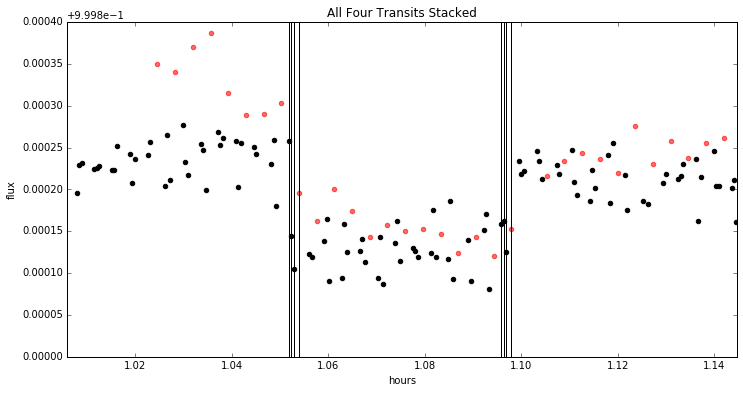

In [417]:
# Stacked transits
width_around_eclipse = 1.5
ylim = [1-2e-4, 1+2e-4]

fig61 = plt.figure(figsize=(12,6))
ax1 = fig61.add_subplot(111)
# transits
ax1.scatter(e1_data_hour_good_norm, e1_flux_detrended, marker='o', color='black')
ax1.scatter(e2_data_hour_good_norm, e2_flux_detrended, marker='o', color='red', alpha=.6) #bad detrend!
ax1.scatter(e3_data_hour_good_norm, e3_flux_detrended, marker='o', color='black')
ax1.scatter(e4_data_hour_good_norm, e4_flux_detrended, marker='o', color='black')

# transits start & end
start1 = 192
end1 = 204
ax1.plot([e1_data_hour_good_norm[start1], e1_data_hour_good_norm[start1]], ylim, color='black')
ax1.plot([e1_data_hour_good_norm[end1], e1_data_hour_good_norm[end1]], ylim, color='black')
start2 = 8
end2 = 20
ax1.plot([e2_data_hour_good_norm[start2], e2_data_hour_good_norm[start2]], ylim, color='black')
ax1.plot([e2_data_hour_good_norm[end2], e2_data_hour_good_norm[end2]], ylim, color='black')
start3 = 120
end3 = 132
ax1.plot([e3_data_hour_good_norm[start3], e3_data_hour_good_norm[start3]], ylim, color='black')
ax1.plot([e3_data_hour_good_norm[end3], e3_data_hour_good_norm[end3]], ylim, color='black')
start4 = 237
end4 = 247
ax1.plot([e4_data_hour_good_norm[start4], e4_data_hour_good_norm[start4]], ylim, color='black')
ax1.plot([e4_data_hour_good_norm[end4], e4_data_hour_good_norm[end4]], ylim, color='black')

#plotting lims
ax1.set_xlim([first_transit_time_hour_normalized - width_around_eclipse * eclipse_duration_hour, 
              first_transit_time_hour_normalized + width_around_eclipse * eclipse_duration_hour])
ax1.set_ylim(ylim)

ax1.set_xlabel('hours')
ax1.set_ylabel('flux')
ax1.set_title('All Four Transits Stacked')

fig61.show()
fig61.savefig('../figures/4_transits.pdf')

#### Second eclipes detrend is quite bad due to it being close to the edge

### Depth measurement

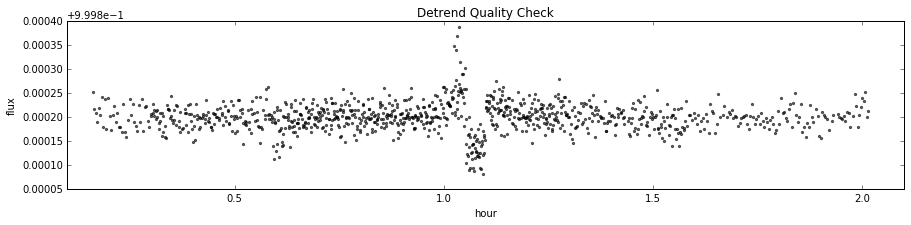

In [407]:
# detrending quality check
fig7 = plt.figure(figsize=(15,3))
ax1 = fig7.add_subplot(111)

ax1.scatter(e1_data_hour_good_norm, e1_flux_detrended, marker='.', color='black', alpha=.6)
ax1.scatter(e2_data_hour_good_norm, e2_flux_detrended, marker='.', color='black', alpha=.6)
ax1.scatter(e3_data_hour_good_norm, e3_flux_detrended, marker='.', color='black', alpha=.6)
ax1.scatter(e4_data_hour_good_norm, e4_flux_detrended, marker='.', color='black', alpha=.6)
#ax1.plot([-.5,2.5],[1,1])

ax1.set_ylim([1-1.5e-4, 1+2e-4])
ax1.set_xlim([0.1,2.1])

ax1.set_xlabel('hour')
ax1.set_ylabel('flux')
ax1.set_title('Detrend Quality Check')
fig7.show()
fig7.savefig('../figures/detrend_quality.pdf')

In [408]:
# detrended flux in and out of the eclipes
# flux during the eclipse
agg_eclipse_detrended_flux = np.hstack((e1_flux_detrended[start1:end1+1],
                                        e2_flux_detrended[start2:end2+1],
                                        e3_flux_detrended[start3:end3+1],
                                        e4_flux_detrended[start4:end4+1]))

# flux outside of the eclipse
agg_detrended_flux = np.hstack((e1_flux_detrended[:start1], e1_flux_detrended[end1+1:],
                                e2_flux_detrended[:start2], e2_flux_detrended[end2+1:],
                                e3_flux_detrended[:start3], e3_flux_detrended[end3+1:],
                                e4_flux_detrended[:start4], e4_flux_detrended[end4+1:],))

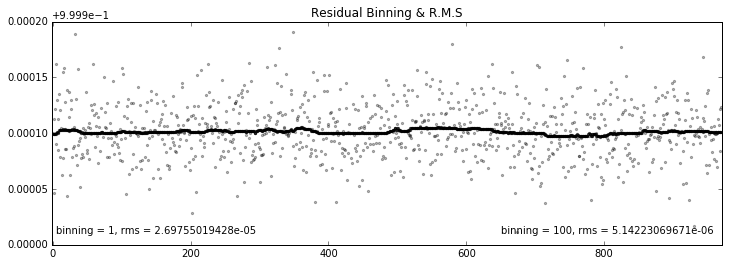

In [409]:
# RMS v bin plot
fig71 = plt.figure(figsize=(12,4))
ax1 = fig71.add_subplot(111)
# bin = 1
agg_detrended_flux_bin1 = agg_detrended_flux
np.random.shuffle(agg_detrended_flux_bin1)
ax1.scatter(range(len(agg_detrended_flux_bin1)), agg_detrended_flux_bin1, color='black', marker='.', alpha=.3)
# bin = 100
binning = 100
agg_detrended_flux_bin2 = moving_smooth(agg_detrended_flux_bin1, binning, 'median')
ax1.scatter(range(len(agg_detrended_flux_bin2)), agg_detrended_flux_bin2, color='black', marker='.', alpha=.6)

# RMS
ax1.text(5, 1-.9e-4, 'binning = {0}, rms = {1}'.format(1, np.std(agg_detrended_flux)))
ax1.text(650, 1-.9e-4, 'binning = {0}, rms = {1}'.format(binning, np.std(agg_detrended_flux_bin)))

ax1.set_ylim([1-1e-4, 1+1e-4])
ax1.set_xlim([-1,len(agg_detrended_flux)])
ax1.set_title('Residual Binning & R.M.S')
fig71.show()
fig71.savefig('../figures/binning_rms.pdf')

In [410]:
# errors
agg_detrended_flux_err = np.hstack((e1_data_flux_err_good[:start1], e1_data_flux_err_good[end1+1:],
                                    e2_data_flux_err_good[:start2], e2_data_flux_err_good[end2+1:],
                                    e3_data_flux_err_good[:start3], e3_data_flux_err_good[end3+1:],
                                    e4_data_flux_err_good[:start4], e4_data_flux_err_good[end4+1:]))

In [411]:
# weighted residuals
weighted_res = (agg_detrended_flux/np.mean(agg_detrended_flux))/agg_detrended_flux_err

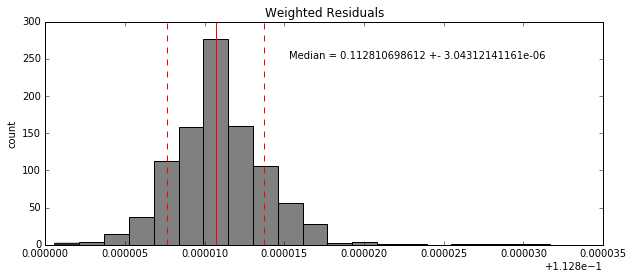

In [412]:
# weighted residuals plot
fig72 = plt.figure(figsize=(10,4))
ax1 = fig72.add_subplot(111)
b = np.linspace(np.min(weighted_res), np.max(weighted_res), 21)
ax1.hist(weighted_res, b, color='grey')

# median & std
ax1.plot([np.median(weighted_res), np.median(weighted_res)], [0,300], color='red')
ax1.plot([np.median(weighted_res) - np.std(weighted_res), np.median(weighted_res) - np.std(weighted_res)], 
         [0,300], '--', color='red')
ax1.plot([np.median(weighted_res) + np.std(weighted_res), np.median(weighted_res) + np.std(weighted_res)], 
         [0,300], '--', color='red')

ax1.text(np.median(weighted_res) + 1.5*np.std(weighted_res), 250, 
         'Median = {0} +- {1}'.format(np.median(weighted_res), np.std(weighted_res)))


ax1.set_title('Weighted Residuals')
ax1.set_ylabel('count')
fig72.show()
fig72.savefig('../figures/weighted_residuals.pdf')

### Eclipse depth?

In [384]:
print('The eclipse causes a {0}% +- {1}% decrease of the total flux!'
      .format((1 - np.mean(agg_eclipse_detrended_flux)/np.mean(agg_detrended_flux))*100,
              np.std(agg_eclipse_detrended_flux)*100))

The eclipse causes a 0.00648782523042% +- 0.00328738512674% decrease of the total flux!
